### <font color='orange'>Общее впечатление (ревью 3)</font>
* После исправлений проект улучшился и теперь он может быть зачтен.
* Теперь все утечки исправлены и требуемое качество честно достигнуто.
* Удачи в дальнейшем обучении и следующих работах!

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Общее-впечатление-(ревью-3)" data-toc-modified-id="Общее-впечатление-(ревью-3)-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 3)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импортируем все необходимые библиотеки

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer, mean_squared_error as mse

In [4]:
data = pd.read_csv('./datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [5]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [6]:
print('Порядок индекса монотонен?', data.index.is_monotonic)

Порядок индекса монотонен? True


In [7]:
data.isna().sum()

num_orders    0
dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

Иссследуем данные на сезонность и тренд

In [9]:
decomposed = seasonal_decompose(data)

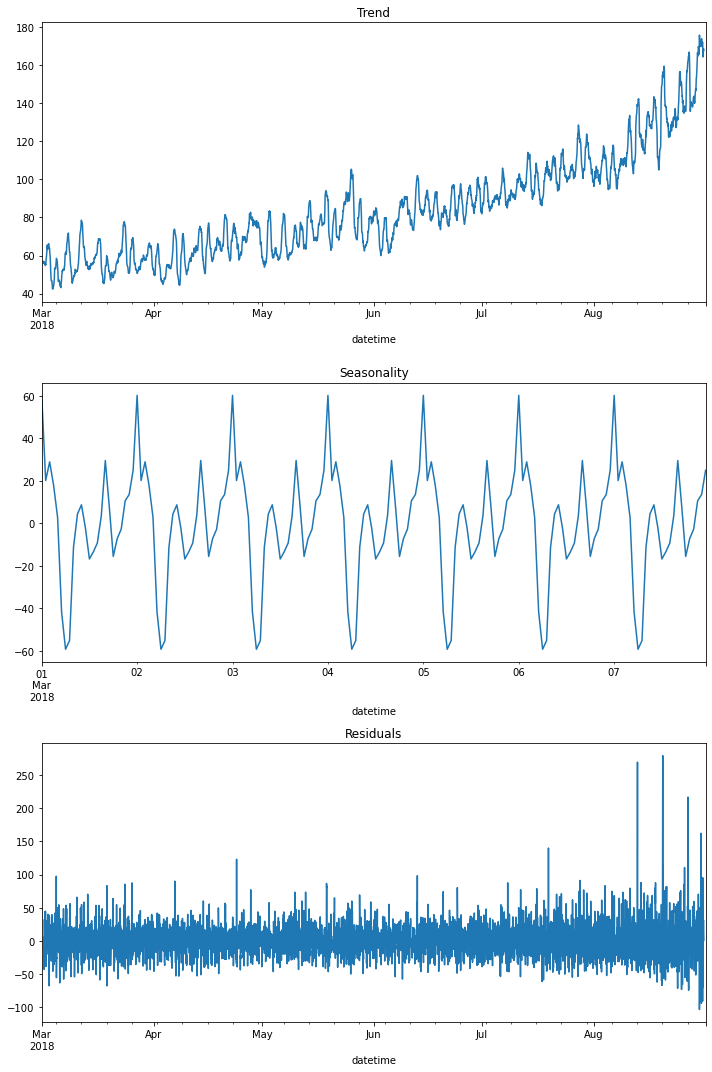

In [10]:
plt.figure(figsize=(10, 15))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.head(24*7).plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Больше всего заказов такси приходится на 00 часов. Выскажу предположение о том, что в этот момент прилетает много самолетов и отсустствует дополнительный наземный транспорт, которым можно добраться из аэропорта.
Минимальное количество заказов в районе 6-7 часов утра.
Так же заметен второй по величине пик заказов в районе 16-17 дня

<AxesSubplot:xlabel='datetime'>

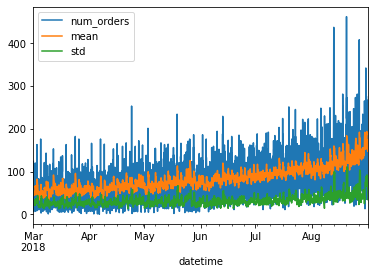

In [11]:
data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()
data.plot() 

На графиках, представленных выше, мы можем наблюдать растущий тренд заказов у агрегатора такси. Сложно выледить факторы, способствующие росту заказов, временной интервал, предоставленных в датасете не позволяет это сделать.

На графике сезонности можно наблюдать сезонность заказов у агрегатора в пределах одной недели. График стационарный. Можно выделить, что ближе к час-пику количество заказов достигает максимального пика.

## Обучение

Чтобы обучить модели МL, нам необходимо создать признаки

Удалим созданные колонки для построения графиков, чтобы избежать утечки данных

In [12]:
data = data.drop(columns=['mean','std'])

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [14]:
make_features(data, 24, 50)

In [15]:
data.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разобъем выборки на тестовую, валидационную и обучающую, а так же удалим все пропущенные значения на обучающей выборке

In [16]:
train, valid_test = train_test_split(data, shuffle=False, test_size=0.2)
valid, test = train_test_split(valid_test, shuffle=False, test_size=0.5)
train = train.dropna()

Проверим размерности выборок

In [17]:
print('Размер обучающей выборки:', train.shape)
print('Размер валидационной выборки:', valid.shape)
print('Размер тестовой выборки:', test.shape)

Размер обучающей выборки: (3482, 30)
Размер валидационной выборки: (442, 30)
Размер тестовой выборки: (442, 30)


Определим таргет и признаки

In [18]:
features_train =  train.drop(columns=['num_orders'])
target_train = train['num_orders']
features_valid =  valid.drop(columns=['num_orders'])
target_valid = valid['num_orders']
features_test = test.drop(columns=['num_orders'])
target_test = test['num_orders']

Оценим модель прогнозом константы. Заполним предсказания средним числом заказов 

In [19]:
target_valid_med = np.ones(target_valid.shape) * target_train.median()
target_test_med = np.ones(target_test.shape) * target_train.median()

print("RMSE valid:", mse(target_valid, target_valid_med)**0.5)
print("RMSE test:", mse(target_test, target_test_med)**0.5)

RMSE valid: 59.68095795210938
RMSE test: 89.39768286346948


На тесте модель показала  89, что не является удовлетворительным результатом. Постараемся минимализировать значение RMSE

Для оценки моделей создадим функцию, которая на вход принимает модель, а в качестве рузельтата считает rmse модели.

In [20]:
def model_time_rmse(model, X_train, y_train, X_test, y_test):
      
    y_pred = model.predict(X_test)
    
    return mse(y_test, y_pred)**0.5

In [21]:
results = []

Для обучения будут использованы модели: Линейная регрессия, Случайный лес в регрессии, LGBMRegressor и CatBoostRegressor

Начнем с простой линейной регрессии

In [22]:
lr = LinearRegression()

In [23]:
%%time
lr.fit(features_train, target_train)

CPU times: user 12 ms, sys: 20 ms, total: 32 ms
Wall time: 11.8 ms


LinearRegression()

In [24]:
results.append(model_time_rmse(lr, features_train, target_train, features_valid, target_valid))

Рассмотрим случпйный лес в регрессии

In [25]:
cv = TimeSeriesSplit()

In [26]:
rf = RandomForestRegressor()

In [27]:
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2),
}

In [28]:
grid = GridSearchCV(rf, 
                    parametrs, 
                    cv=cv,
                    verbose=True)

In [29]:
%%time
grid.fit(features_train, target_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
CPU times: user 39.8 s, sys: 0 ns, total: 39.8 s
Wall time: 39.8 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 13, 2),
                         'n_estimators': range(10, 51, 10)},
             verbose=True)

In [30]:
grid.best_params_

{'max_depth': 11, 'n_estimators': 50}

In [31]:
results.append(model_time_rmse(grid.best_estimator_, features_train, target_train, features_valid, target_valid))

Переходим к ансамблю LGBMRegressor

In [32]:
lgbm = LGBMRegressor(boosting_type='gbdt', verbose=0)

In [33]:
parametrs = {
    'learning_rate': np.logspace(-3, 0, 5),
    'n_estimators': [100, 150],
    'num_leaves': [21, 31, 41],
}

In [34]:
grid = GridSearchCV(lgbm,
                    parametrs,
                    cv=cv,
                    scoring='neg_mean_squared_error',
                    verbose=True)

In [35]:
%%time
grid.fit(features_train, target_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You ca

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(verbose=0),
             param_grid={'learning_rate': array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ]),
                         'n_estimators': [100, 150],
                         'num_leaves': [21, 31, 41]},
             scoring='neg_mean_squared_error', verbose=True)

In [36]:
grid.best_params_

{'learning_rate': 0.03162277660168379, 'n_estimators': 150, 'num_leaves': 21}

In [37]:
results.append(model_time_rmse(grid.best_estimator_, features_train, target_train, features_valid, target_valid))

И помледняя модель это CatBoostRegressor

In [38]:
cb = CatBoostRegressor(loss_function='RMSE',
                            silent=True)

In [39]:
parametrs = {
    'learning_rate': np.logspace(-3, 0, 5),
    'iterations': [40, 60],
    'depth': [6, 8, 10],
}

In [40]:
grid = GridSearchCV(cb,
                    parametrs,
                    cv=cv,
                    scoring='neg_mean_squared_error',
                    verbose=False,
                    error_score='raise')

In [41]:
%%time
grid.fit(features_train, target_train)

CPU times: user 7min 52s, sys: 15 s, total: 8min 7s
Wall time: 1min 14s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             error_score='raise',
             estimator=<catboost.core.CatBoostRegressor object at 0x7fd318005c70>,
             param_grid={'depth': [6, 8, 10], 'iterations': [40, 60],
                         'learning_rate': array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ])},
             scoring='neg_mean_squared_error', verbose=False)

In [42]:
grid.best_params_

{'depth': 6, 'iterations': 60, 'learning_rate': 0.1778279410038923}

In [43]:
results.append(model_time_rmse(grid.best_estimator_, features_train, target_train, features_valid, target_valid))

In [44]:
result = pd.DataFrame(data=results,
             index=['LinearRegression', 'RandomForestRegressor', 'LightGBM', 'CatBoost'],
             columns=['score'])

pd.options.display.float_format ='{:,.3f}'.format

In [45]:
result

,score
LinearRegression,34.346
RandomForestRegressor,32.604
LightGBM,32.075
CatBoost,32.646


Лучшей моделью оказался ансамбль LightGBM, проверим его на тесте, при этом обучм его на train+valid

## Тестирование

In [46]:
features_train =  train.drop(columns=['num_orders'])
target_train = train['num_orders']
features_valid =  valid.drop(columns=['num_orders'])
target_valid = valid['num_orders']
features_test = test.drop(columns=['num_orders'])
target_test = test['num_orders']

In [47]:
features_train_valid = pd.concat([features_train, features_valid], sort=False, axis=0)

In [48]:
target_train_valid = pd.concat([target_train, target_valid], sort=False, axis=0)

In [51]:
model = LGBMRegressor(learning_rate = 0.03162277660168379, 
                      n_estimators=150, 
                      num_leaves=21,
                      boosting_type='gbdt')

In [52]:
%%time
model.fit(features_train_valid, target_train_valid)

CPU times: user 2.71 s, sys: 20 ms, total: 2.73 s
Wall time: 407 ms


LGBMRegressor(learning_rate=0.03162277660168379, n_estimators=150,
              num_leaves=21)

In [53]:
model_time_rmse(model, features_train_valid, target_train_valid, features_test, target_test)

43.24287896420827

In [54]:
prediction = model.predict(features_test)

Изобразим разницу в предсказании на графиках

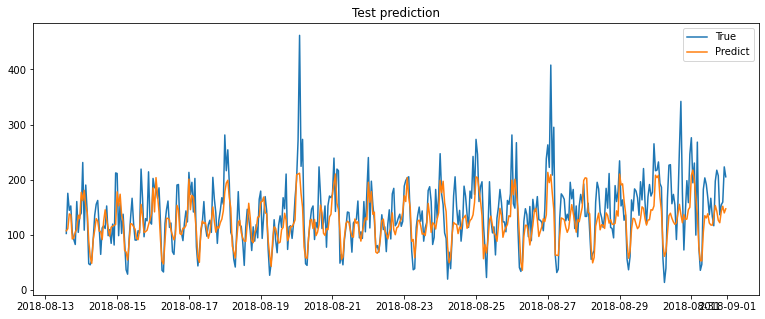

In [69]:
plt.figure(figsize=(13, 5))

plt.plot(target_test, label='True')
plt.plot(target_test.index, prediction, label='Predict')

plt.title('Test prediction')
plt.legend()
plt.show()

Несмотря на то, что нам удалось добиться показателя RMSE меньше 48 (а именно, 43,2 на тестовой выборке), график показал, что модель полностью игнорирует пиковые нагрузки. Разница в 43 заказа очень существена.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48